# Lottery Ticket Hypothesis on Quick, Draw! — CNN

This notebook implements the Iterative Magnitude Pruning (IMP) algorithm on a CNN for the Quick, Draw! dataset
Run the 0 notebook first

## 1. Setup and imports

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [2]:
# Vérifier le device disponible
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Device: {device}")

Device: cuda


In [3]:
data_root = './data/quickdraw'
checkpoint_path = 'checkpoints'
categories = ['apple', 'banana', 'basketball', 'bicycle', 'book', 
              'car', 'cat', 'clock', 'cloud', 'eye']

samples_per_class = 10000
train_split = 0.8
batch_size = 128
learning_rate = 1e-3
seed = 67

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.manual_seed(seed)
np.random.seed(seed)

## 2. data download

In [4]:
class QuickDrawDataset(Dataset):
    def __init__(self, root, categories, samples_per_class=10000, train=True, train_split=0.8):
        self.data = []
        self.labels = []
        
        for idx, cat in enumerate(categories):
            images = np.load(os.path.join(root, f'{cat}.npy'))[:samples_per_class]
            split_idx = int(len(images) * train_split)
            images = images[:split_idx] if train else images[split_idx:]
            self.data.append(images)
            self.labels.extend([idx] * len(images))
        
        self.data = np.concatenate(self.data)
        self.labels = np.array(self.labels)
        
        # Shuffle
        perm = np.random.permutation(len(self.data))
        self.data, self.labels = self.data[perm], self.labels[perm]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx].reshape(28, 28) / 255.0, dtype=torch.float32).unsqueeze(0)
        return image, torch.tensor(self.labels[idx], dtype=torch.long)

In [5]:
def get_loaders(categories):
    train_dataset = QuickDrawDataset(data_root, categories, samples_per_class, train=True)
    val_dataset = QuickDrawDataset(data_root, categories, samples_per_class, train=False)
    return (DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            DataLoader(val_dataset, batch_size=batch_size))

train_loader, val_loader = get_loaders(categories)

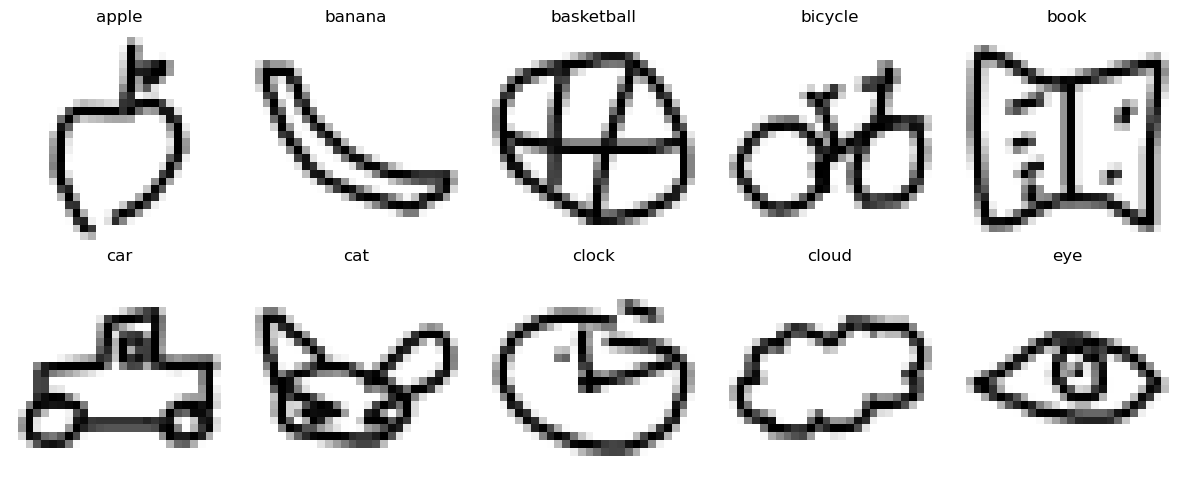

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
train_dataset = train_loader.dataset
for i, ax in enumerate(axes.flat):
    idx = np.where(train_dataset.labels == i)[0][0]
    ax.imshow(255 - train_dataset.data[idx].reshape(28, 28), cmap='gray')
    ax.set_title(categories[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Definition of the CNN model

In [7]:
class QuickDrawCNN(nn.Module):    
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Couches convolutives
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Couches fully connected
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout pour régularisation
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Conv blocks avec pooling
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # 28 -> 14
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # 14 -> 7
        x = F.relu(F.max_pool2d(self.conv3(x), 2))  # 7 -> 3
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [8]:
# create the model
model = QuickDrawCNN(num_classes=len(categories)).to(device)

print(f"Architecture CNN:")
for name, param in model.named_parameters():
    print(f"  {name}: {param.numel():,} params")
     
# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
print(f"total parameters: {total_params:,}")

Architecture CNN:
  conv1.weight: 288 params
  conv1.bias: 32 params
  conv2.weight: 18,432 params
  conv2.bias: 64 params
  conv3.weight: 73,728 params
  conv3.bias: 128 params
  fc1.weight: 294,912 params
  fc1.bias: 256 params
  fc2.weight: 2,560 params
  fc2.bias: 10 params
total parameters: 390,410


## 4. training and evaluation

In [9]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """train the model for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    
    return total_loss / len(train_loader), correct / total


def evaluate(model, val_loader, device):
    """evaluate the model on the val set"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    
    return correct / total


def train_model(model, train_loader, val_loader, epochs, lr, device, verbose=True):
    """train the complete model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    
    pbar = tqdm(range(epochs), disable=not verbose)
    for epoch in pbar:
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_acc = evaluate(model, val_loader, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        pbar.set_description(f"Loss: {train_loss:.4f}, Train: {train_acc:.2%}, Val: {val_acc:.2%}")
    
    return history

## 5. Training of the dense model (baseline)

**Warning**: Save θ₀ before the training

In [10]:
os.makedirs(checkpoint_path, exist_ok=True)

model = QuickDrawCNN(num_classes=len(categories)).to(device)
initial_weights = copy.deepcopy(model.state_dict())

theta0_path = os.path.join(checkpoint_path, 'cnn_theta_0.pt')
torch.save(initial_weights, theta0_path)
print(f"θ₀ saved in {theta0_path}")

θ₀ saved in checkpoints\cnn_theta_0.pt


In [ ]:
seeds = [42, 67, 123, 2024, 99, 69, 7, 56, 74, 2026]
epochs = 20
all_histories = []
all_baseline_accs = []

epochs_per_iteration = 8
prune_rate = 0.7
imp_iterations = 5

for seed in seeds:
    print(f"Training Seed {seed}")
    
    torch.manual_seed(seed)
    if device.type == 'cuda':
        torch.cuda.manual_seed(seed)
    
    model = QuickDrawCNN(num_classes=len(categories)).to(device)
    
    
    # train
    history = train_model(
        model, 
        train_loader, 
        val_loader, 
        epochs = epochs, 
        lr = learning_rate, 
        device = device
    )
    all_histories.append(history)
    
    # evaluate
    acc = evaluate(model, val_loader, device)
    all_baseline_accs.append(acc)
    
    del model
    
baseline_acc = np.mean(all_baseline_accs)

Training Seed 42


Loss: 0.0251, Train: 99.15%, Val: 95.97%: 100%|██████████| 20/20 [01:23<00:00,  4.20s/it]


Training Seed 67


Loss: 0.0226, Train: 99.19%, Val: 95.78%: 100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


Training Seed 123


Loss: 0.0224, Train: 99.24%, Val: 96.09%: 100%|██████████| 20/20 [01:24<00:00,  4.21s/it]


Training Seed 2024


Loss: 0.0241, Train: 99.17%, Val: 95.97%: 100%|██████████| 20/20 [01:25<00:00,  4.29s/it]


Training Seed 99


Loss: 0.0230, Train: 99.19%, Val: 95.80%: 100%|██████████| 20/20 [01:25<00:00,  4.26s/it]


Training Seed 69


Loss: 0.0225, Train: 99.20%, Val: 95.92%: 100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


Training Seed 7


Loss: 0.0225, Train: 99.23%, Val: 95.84%: 100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


Training Seed 56


Loss: 0.0209, Train: 99.30%, Val: 96.06%: 100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


Training Seed 74


Loss: 0.0240, Train: 99.19%, Val: 95.83%: 100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


Training Seed 2026


Loss: 0.0221, Train: 99.23%, Val: 95.75%: 100%|██████████| 20/20 [01:23<00:00,  4.16s/it]


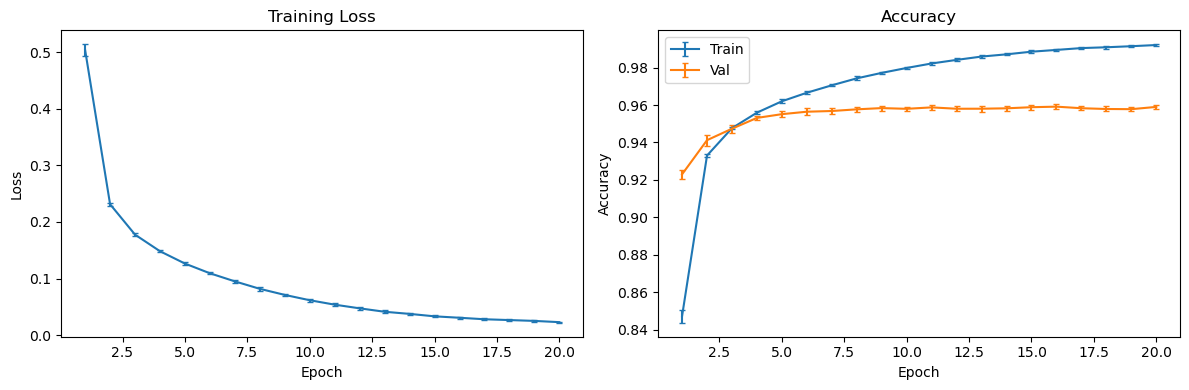

In [18]:
train_losses = np.array([h['train_loss'] for h in all_histories])
train_accs = np.array([h['train_acc'] for h in all_histories])
val_accs = np.array([h['val_acc'] for h in all_histories])

# Moyenne par colonne (axis=0)
loss_avg = train_losses.mean(axis=0)
t_acc_avg = train_accs.mean(axis=0)
v_acc_avg = val_accs.mean(axis=0)

# Accuracy finale moyenne pour ta baseline LTH
baseline_acc = np.mean(all_baseline_accs)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
epochs = range(1, 21)

# Plot Loss
axes[0].errorbar(epochs, loss_avg, yerr=train_losses.std(0), capsize=2, label='Loss')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot Accuracy
axes[1].errorbar(epochs, t_acc_avg, yerr=train_accs.std(0), capsize=2,label='Train')
axes[1].errorbar(epochs, v_acc_avg, yerr=val_accs.std(0), capsize=2, label='Val')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [10]:
model = QuickDrawCNN(num_classes=len(categories)).to(device)

history_dense = train_model(
    model, 
    train_loader, 
    val_loader, 
    20, 
    learning_rate, 
    device)

torch.save(model.state_dict(), os.path.join(checkpoint_path, 'cnn_theta_final.pt'))

baseline_acc = evaluate(model, val_loader, device)
print(f"Accuracy baseline (modèle dense): {baseline_acc:.2%}")

Loss: 0.0244, Train: 99.15%, Val: 95.64%: 100%|██████████| 20/20 [01:26<00:00,  4.31s/it]


Accuracy baseline (modèle dense): 95.64%


## 6. Implementation IMP (Iterative Magnitude Pruning)

In [11]:
def run_lth(prune_rate, iterations, theta_0_path):
    print(f"Start: Rate {prune_rate} ({iterations} itérations)")
    
    #init
    model = QuickDrawCNN(num_classes=len(categories)).to(device)
    theta_0 = torch.load(theta_0_path, map_location=device)
    model.load_state_dict(theta_0)
    
    history = []
    
    for i in range(iterations):
        # Train
        train_model(model, train_loader, val_loader, epochs=5, lr=1e-3, device=device)
        acc = evaluate(model, val_loader, device)
        
        # Mesure Sparsity
        zeros = sum((m.weight == 0).sum().item() for m in model.modules() if hasattr(m, 'weight'))
        total = sum(m.weight.numel() for m in model.modules() if hasattr(m, 'weight'))
        sparsity = zeros / total
        
        print(f"Iter {i+1}: Acc={acc:.2%} | Sparsité={sparsity:.1%}")
        history.append({'sparsity': sparsity, 'accuracy': acc})
        
        # Prune & Reset
        if i < iterations - 1:
            # Pruning
            params = [(m, 'weight') for m in model.modules() if isinstance(m, (nn.Conv2d, nn.Linear))]
            prune.global_unstructured(params, pruning_method=prune.L1Unstructured, amount=prune_rate)
            
            # Reset (Sauvegarde masque -> Nettoyage -> Charge Theta0 -> Applique masque)
            masks = {name: m.weight_mask.clone() for name, m in model.named_modules() if hasattr(m, 'weight_mask')}
            for m, _ in params: prune.remove(m, 'weight')
            model.load_state_dict(theta_0)
            for name, m in model.named_modules():
                if name in masks: prune.custom_from_mask(m, 'weight', masks[name])
                
    return history

In [12]:
seeds = [42, 67, 123]
rates_to_test = [(0.2, 20), (0.5, 8), (0.7, 5)]  # (rate, iterations)

data = {rate: {seed: {} for seed in seeds} for rate, _ in rates_to_test}

# training
for seed in seeds:
    print(f"seed {seed}")
    torch.manual_seed(seed)
    path_theta_0 = os.path.join(checkpoint_path, f'cnn_theta_0_seed_{seed}.pt')
    torch.save(QuickDrawCNN(num_classes=len(categories)).state_dict(), path_theta_0)
    
    for rate, iters in rates_to_test:
        print(f"   Pruning Rate {rate} ({iters} itérations)")
        history = run_lth(prune_rate=rate, iterations=iters, theta_0_path=path_theta_0)
        data[rate][seed] = {
            'acc': [r['accuracy'] for r in history],
            'rem': [(1 - r['sparsity']) * 100 for r in history]
        }

seed 42
   Pruning Rate 0.2 (20 itérations)
Start: Rate 0.2 (20 itérations)


Loss: 0.1319, Train: 96.06%, Val: 95.30%: 100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


Iter 1: Acc=95.30% | Sparsité=0.0%


Loss: 0.1308, Train: 96.05%, Val: 95.44%: 100%|██████████| 5/5 [00:22<00:00,  4.44s/it]


Iter 2: Acc=95.44% | Sparsité=20.0%


Loss: 0.1277, Train: 96.15%, Val: 95.63%: 100%|██████████| 5/5 [00:22<00:00,  4.44s/it]


Iter 3: Acc=95.63% | Sparsité=36.0%


Loss: 0.1245, Train: 96.22%, Val: 95.78%: 100%|██████████| 5/5 [00:22<00:00,  4.47s/it]


Iter 4: Acc=95.78% | Sparsité=48.8%


Loss: 0.1187, Train: 96.44%, Val: 95.49%: 100%|██████████| 5/5 [00:22<00:00,  4.43s/it]


Iter 5: Acc=95.49% | Sparsité=59.0%


Loss: 0.1160, Train: 96.50%, Val: 95.59%: 100%|██████████| 5/5 [00:22<00:00,  4.47s/it]


Iter 6: Acc=95.59% | Sparsité=67.2%


Loss: 0.1111, Train: 96.60%, Val: 95.68%: 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


Iter 7: Acc=95.68% | Sparsité=73.8%


Loss: 0.1095, Train: 96.69%, Val: 95.35%: 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


Iter 8: Acc=95.35% | Sparsité=79.0%


Loss: 0.1078, Train: 96.69%, Val: 95.51%: 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


Iter 9: Acc=95.51% | Sparsité=83.2%


Loss: 0.1074, Train: 96.68%, Val: 95.69%: 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


Iter 10: Acc=95.69% | Sparsité=86.6%


Loss: 0.1093, Train: 96.63%, Val: 95.78%: 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


Iter 11: Acc=95.78% | Sparsité=89.3%


Loss: 0.1122, Train: 96.54%, Val: 95.62%: 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


Iter 12: Acc=95.62% | Sparsité=91.4%


Loss: 0.1193, Train: 96.45%, Val: 95.56%: 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]


Iter 13: Acc=95.56% | Sparsité=93.1%


Loss: 0.1324, Train: 95.99%, Val: 95.45%: 100%|██████████| 5/5 [00:23<00:00,  4.76s/it]


Iter 14: Acc=95.45% | Sparsité=94.5%


Loss: 0.1465, Train: 95.65%, Val: 95.30%: 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]


Iter 15: Acc=95.30% | Sparsité=95.6%


Loss: 0.1661, Train: 95.06%, Val: 94.89%: 100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


Iter 16: Acc=94.89% | Sparsité=96.5%


Loss: 0.1923, Train: 94.35%, Val: 94.58%: 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


Iter 17: Acc=94.58% | Sparsité=97.2%


Loss: 0.2251, Train: 93.40%, Val: 94.06%: 100%|██████████| 5/5 [00:23<00:00,  4.68s/it]


Iter 18: Acc=94.06% | Sparsité=97.7%


Loss: 0.2502, Train: 92.76%, Val: 93.69%: 100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


Iter 19: Acc=93.69% | Sparsité=98.2%


Loss: 0.2870, Train: 91.82%, Val: 93.00%: 100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


Iter 20: Acc=93.00% | Sparsité=98.6%
   Pruning Rate 0.5 (8 itérations)
Start: Rate 0.5 (8 itérations)


Loss: 0.1286, Train: 96.16%, Val: 95.66%: 100%|██████████| 5/5 [00:22<00:00,  4.49s/it]


Iter 1: Acc=95.66% | Sparsité=0.0%


Loss: 0.1217, Train: 96.31%, Val: 95.09%: 100%|██████████| 5/5 [00:23<00:00,  4.74s/it]


Iter 2: Acc=95.09% | Sparsité=50.0%


Loss: 0.1121, Train: 96.61%, Val: 95.54%: 100%|██████████| 5/5 [00:23<00:00,  4.80s/it]


Iter 3: Acc=95.54% | Sparsité=75.0%


Loss: 0.1085, Train: 96.69%, Val: 95.71%: 100%|██████████| 5/5 [00:24<00:00,  4.88s/it]


Iter 4: Acc=95.71% | Sparsité=87.5%


Loss: 0.1319, Train: 96.00%, Val: 95.38%: 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


Iter 5: Acc=95.38% | Sparsité=93.8%


Loss: 0.1963, Train: 94.25%, Val: 94.33%: 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


Iter 6: Acc=94.33% | Sparsité=96.9%


Loss: 0.3360, Train: 90.46%, Val: 92.16%: 100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


Iter 7: Acc=92.16% | Sparsité=98.4%


Loss: 0.5527, Train: 83.76%, Val: 88.43%: 100%|██████████| 5/5 [00:23<00:00,  4.74s/it]


Iter 8: Acc=88.43% | Sparsité=99.2%
   Pruning Rate 0.7 (5 itérations)
Start: Rate 0.7 (5 itérations)


Loss: 0.1291, Train: 96.17%, Val: 95.74%: 100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


Iter 1: Acc=95.74% | Sparsité=0.0%


Loss: 0.1127, Train: 96.60%, Val: 95.58%: 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


Iter 2: Acc=95.58% | Sparsité=70.0%


Loss: 0.1226, Train: 96.37%, Val: 95.44%: 100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


Iter 3: Acc=95.44% | Sparsité=91.0%


Loss: 0.2578, Train: 92.64%, Val: 93.30%: 100%|██████████| 5/5 [00:23<00:00,  4.74s/it]


Iter 4: Acc=93.30% | Sparsité=97.3%


Loss: 0.7775, Train: 76.12%, Val: 83.65%: 100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


Iter 5: Acc=83.65% | Sparsité=99.2%
seed 67
   Pruning Rate 0.2 (20 itérations)
Start: Rate 0.2 (20 itérations)


Loss: 0.1262, Train: 96.16%, Val: 95.73%: 100%|██████████| 5/5 [00:22<00:00,  4.52s/it]


Iter 1: Acc=95.73% | Sparsité=0.0%


Loss: 0.1274, Train: 96.14%, Val: 95.46%: 100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


Iter 2: Acc=95.46% | Sparsité=20.0%


Loss: 0.1260, Train: 96.20%, Val: 95.25%: 100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


Iter 3: Acc=95.25% | Sparsité=36.0%


Loss: 0.1217, Train: 96.30%, Val: 95.62%: 100%|██████████| 5/5 [00:25<00:00,  5.09s/it]


Iter 4: Acc=95.62% | Sparsité=48.8%


Loss: 0.1190, Train: 96.40%, Val: 95.32%: 100%|██████████| 5/5 [00:24<00:00,  4.86s/it]


Iter 5: Acc=95.32% | Sparsité=59.0%


Loss: 0.1146, Train: 96.51%, Val: 95.60%: 100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


Iter 6: Acc=95.60% | Sparsité=67.2%


Loss: 0.1111, Train: 96.60%, Val: 95.49%: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Iter 7: Acc=95.49% | Sparsité=73.8%


Loss: 0.1083, Train: 96.69%, Val: 95.44%: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Iter 8: Acc=95.44% | Sparsité=79.0%


Loss: 0.1071, Train: 96.74%, Val: 95.62%: 100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


Iter 9: Acc=95.62% | Sparsité=83.2%


Loss: 0.1060, Train: 96.79%, Val: 95.45%: 100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


Iter 10: Acc=95.45% | Sparsité=86.6%


Loss: 0.1063, Train: 96.74%, Val: 95.67%: 100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


Iter 11: Acc=95.67% | Sparsité=89.3%


Loss: 0.1101, Train: 96.61%, Val: 95.53%: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


Iter 12: Acc=95.53% | Sparsité=91.4%


Loss: 0.1177, Train: 96.44%, Val: 95.55%: 100%|██████████| 5/5 [00:21<00:00,  4.29s/it]


Iter 13: Acc=95.55% | Sparsité=93.1%


Loss: 0.1284, Train: 96.10%, Val: 95.47%: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


Iter 14: Acc=95.47% | Sparsité=94.5%


Loss: 0.1480, Train: 95.54%, Val: 95.12%: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Iter 15: Acc=95.12% | Sparsité=95.6%


Loss: 0.1644, Train: 95.11%, Val: 94.75%: 100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


Iter 16: Acc=94.75% | Sparsité=96.5%


Loss: 0.1877, Train: 94.50%, Val: 94.64%: 100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


Iter 17: Acc=94.64% | Sparsité=97.2%


Loss: 0.2114, Train: 93.81%, Val: 94.08%: 100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


Iter 18: Acc=94.08% | Sparsité=97.7%


Loss: 0.2497, Train: 92.76%, Val: 93.59%: 100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


Iter 19: Acc=93.59% | Sparsité=98.2%


Loss: 0.2779, Train: 91.98%, Val: 93.25%: 100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


Iter 20: Acc=93.25% | Sparsité=98.6%
   Pruning Rate 0.5 (8 itérations)
Start: Rate 0.5 (8 itérations)


Loss: 0.1290, Train: 96.11%, Val: 95.59%: 100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


Iter 1: Acc=95.59% | Sparsité=0.0%


Loss: 0.1220, Train: 96.29%, Val: 95.48%: 100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


Iter 2: Acc=95.48% | Sparsité=50.0%


Loss: 0.1138, Train: 96.51%, Val: 95.62%: 100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


Iter 3: Acc=95.62% | Sparsité=75.0%


Loss: 0.1089, Train: 96.67%, Val: 95.68%: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Iter 4: Acc=95.68% | Sparsité=87.5%


Loss: 0.1286, Train: 96.14%, Val: 95.36%: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Iter 5: Acc=95.36% | Sparsité=93.8%


Loss: 0.1969, Train: 94.26%, Val: 94.38%: 100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


Iter 6: Acc=94.38% | Sparsité=96.9%


Loss: 0.3615, Train: 89.52%, Val: 91.30%: 100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


Iter 7: Acc=91.30% | Sparsité=98.4%


Loss: 0.6261, Train: 81.42%, Val: 87.36%: 100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


Iter 8: Acc=87.36% | Sparsité=99.2%
   Pruning Rate 0.7 (5 itérations)
Start: Rate 0.7 (5 itérations)


Loss: 0.1242, Train: 96.25%, Val: 95.78%: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Iter 1: Acc=95.78% | Sparsité=0.0%


Loss: 0.1083, Train: 96.68%, Val: 95.80%: 100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


Iter 2: Acc=95.80% | Sparsité=70.0%


Loss: 0.1164, Train: 96.44%, Val: 95.71%: 100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


Iter 3: Acc=95.71% | Sparsité=91.0%


Loss: 0.2415, Train: 93.08%, Val: 93.70%: 100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


Iter 4: Acc=93.70% | Sparsité=97.3%


Loss: 0.6993, Train: 78.89%, Val: 84.94%: 100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


Iter 5: Acc=84.94% | Sparsité=99.2%
seed 123
   Pruning Rate 0.2 (20 itérations)
Start: Rate 0.2 (20 itérations)


Loss: 0.1243, Train: 96.22%, Val: 95.46%: 100%|██████████| 5/5 [00:20<00:00,  4.11s/it]


Iter 1: Acc=95.46% | Sparsité=0.0%


Loss: 0.1223, Train: 96.32%, Val: 95.18%: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Iter 2: Acc=95.18% | Sparsité=20.0%


Loss: 0.1183, Train: 96.45%, Val: 95.66%: 100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


Iter 3: Acc=95.66% | Sparsité=36.0%


Loss: 0.1144, Train: 96.54%, Val: 95.31%: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


Iter 4: Acc=95.31% | Sparsité=48.8%


Loss: 0.1093, Train: 96.63%, Val: 95.54%: 100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


Iter 5: Acc=95.54% | Sparsité=59.0%


Loss: 0.1036, Train: 96.81%, Val: 95.81%: 100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


Iter 6: Acc=95.81% | Sparsité=67.2%


Loss: 0.1018, Train: 96.87%, Val: 95.30%: 100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


Iter 7: Acc=95.30% | Sparsité=73.8%


Loss: 0.0991, Train: 96.94%, Val: 95.74%: 100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


Iter 8: Acc=95.74% | Sparsité=79.0%


Loss: 0.0991, Train: 96.98%, Val: 95.22%: 100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


Iter 9: Acc=95.22% | Sparsité=83.2%


Loss: 0.0998, Train: 96.95%, Val: 95.69%: 100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


Iter 10: Acc=95.69% | Sparsité=86.6%


Loss: 0.0993, Train: 96.96%, Val: 95.38%: 100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


Iter 11: Acc=95.38% | Sparsité=89.3%


Loss: 0.1094, Train: 96.58%, Val: 95.62%: 100%|██████████| 5/5 [00:21<00:00,  4.29s/it]


Iter 12: Acc=95.62% | Sparsité=91.4%


Loss: 0.1150, Train: 96.46%, Val: 95.62%: 100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


Iter 13: Acc=95.62% | Sparsité=93.1%


Loss: 0.1314, Train: 95.96%, Val: 95.32%: 100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


Iter 14: Acc=95.32% | Sparsité=94.5%


Loss: 0.1488, Train: 95.54%, Val: 95.01%: 100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


Iter 15: Acc=95.01% | Sparsité=95.6%


Loss: 0.1692, Train: 95.04%, Val: 94.88%: 100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


Iter 16: Acc=94.88% | Sparsité=96.5%


Loss: 0.1932, Train: 94.27%, Val: 94.49%: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


Iter 17: Acc=94.49% | Sparsité=97.2%


Loss: 0.2214, Train: 93.60%, Val: 94.06%: 100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


Iter 18: Acc=94.06% | Sparsité=97.7%


Loss: 0.2602, Train: 92.49%, Val: 93.49%: 100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


Iter 19: Acc=93.49% | Sparsité=98.2%


Loss: 0.2941, Train: 91.60%, Val: 93.03%: 100%|██████████| 5/5 [00:22<00:00,  4.47s/it]


Iter 20: Acc=93.03% | Sparsité=98.6%
   Pruning Rate 0.5 (8 itérations)
Start: Rate 0.5 (8 itérations)


Loss: 0.1246, Train: 96.20%, Val: 94.95%: 100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


Iter 1: Acc=94.95% | Sparsité=0.0%


Loss: 0.1097, Train: 96.65%, Val: 95.71%: 100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


Iter 2: Acc=95.71% | Sparsité=50.0%


Loss: 0.0968, Train: 97.08%, Val: 95.69%: 100%|██████████| 5/5 [00:22<00:00,  4.47s/it]


Iter 3: Acc=95.69% | Sparsité=75.0%


Loss: 0.0948, Train: 97.09%, Val: 95.88%: 100%|██████████| 5/5 [00:22<00:00,  4.47s/it]


Iter 4: Acc=95.88% | Sparsité=87.5%


Loss: 0.1229, Train: 96.28%, Val: 95.34%: 100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


Iter 5: Acc=95.34% | Sparsité=93.8%


Loss: 0.2017, Train: 94.09%, Val: 94.42%: 100%|██████████| 5/5 [00:22<00:00,  4.49s/it]


Iter 6: Acc=94.42% | Sparsité=96.9%


Loss: 0.3596, Train: 89.68%, Val: 91.56%: 100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


Iter 7: Acc=91.56% | Sparsité=98.4%


Loss: 0.5885, Train: 82.87%, Val: 88.02%: 100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


Iter 8: Acc=88.02% | Sparsité=99.2%
   Pruning Rate 0.7 (5 itérations)
Start: Rate 0.7 (5 itérations)


Loss: 0.1223, Train: 96.28%, Val: 95.59%: 100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


Iter 1: Acc=95.59% | Sparsité=0.0%


Loss: 0.1029, Train: 96.85%, Val: 95.51%: 100%|██████████| 5/5 [00:22<00:00,  4.49s/it]


Iter 2: Acc=95.51% | Sparsité=70.0%


Loss: 0.1118, Train: 96.63%, Val: 95.54%: 100%|██████████| 5/5 [00:22<00:00,  4.53s/it]


Iter 3: Acc=95.54% | Sparsité=91.0%


Loss: 0.2428, Train: 92.99%, Val: 93.67%: 100%|██████████| 5/5 [00:22<00:00,  4.51s/it]


Iter 4: Acc=93.67% | Sparsité=97.3%


Loss: 0.6884, Train: 79.58%, Val: 85.63%: 100%|██████████| 5/5 [00:22<00:00,  4.49s/it]


Iter 5: Acc=85.63% | Sparsité=99.2%


In [ ]:
save_file = os.path.join(checkpoint_path, 'results_lth.pt')

# On sauvegarde dans ce fichier
torch.save(data, save_file)

print(f"results saved in : {save_file}")

Résultats sauvegardés avec succès dans : checkpoints\resultats_lth.pt


## 7. testing of different pruning rates

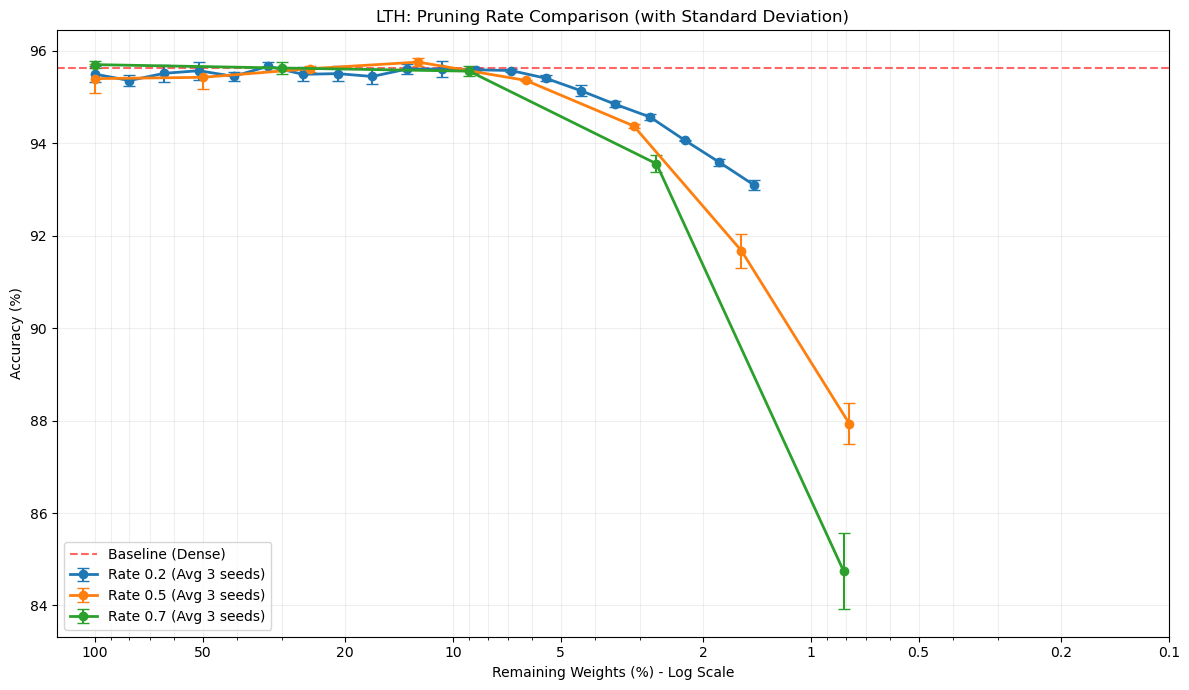

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Configuration
colors = {0.2: '#1f77b4', 0.5: '#ff7f0e', 0.7: '#2ca02c'}
plt.figure(figsize=(12, 7))

for rate, _ in rates_to_test:
    # Retrieve data and calculate statistics
    all_accs = np.array([data[rate][s]['acc'] for s in seeds]) * 100
    mean_acc = all_accs.mean(axis=0)
    std_acc = all_accs.std(axis=0)
    rem = data[rate][seeds[0]]['rem']
    
    # --- PLOTTING WITH ERROR BARS ---
    plt.errorbar(rem, mean_acc, yerr=std_acc, 
                 fmt='o-', 
                 color=colors[rate], 
                 label=f'Rate {rate} (Avg {len(seeds)} seeds)',
                 lw=2,            # Line width
                 elinewidth=1.5,  # Error bar width
                 capsize=4)       # Size of the horizontal caps

# Baseline
if 'baseline_acc' in locals():
    plt.axhline(y=baseline_acc * 100, color='red', ls='--', alpha=0.6, label='Baseline (Dense)')

# --- AXES CONFIGURATION ---
plt.xscale('log')          # Mandatory for log scale when using errorbar
plt.gca().invert_xaxis()   # Invert axis: 100% -> 0.1%

# Manual formatting of X-axis ticks for readability
ticks = [100, 50, 20, 10, 5, 2, 1, 0.5, 0.2, 0.1]
plt.xticks(ticks, [str(t) for t in ticks])

plt.xlabel('Remaining Weights (%) - Log Scale')
plt.ylabel('Accuracy (%)')
plt.title('LTH: Pruning Rate Comparison (with Standard Deviation)')
plt.legend(loc='lower left')
plt.grid(True, which="both", alpha=0.2)
plt.tight_layout()
plt.show()

## 8. testing lottery ticket vs random init

In [ ]:
def clear_memory():
    gc.collect() 
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache() 

In [19]:
seeds = [42, 101, 999] 
imp_iterations = 7
prune_rate = 0.5
epochs_per_iteration = 5
results_per_seed = {} 

# Helper: Calculate actual sparsity
def get_model_sparsity(model):
    zeros = 0
    total = 0
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            zeros += (m.weight == 0).sum().item()
            total += m.weight.numel()
    return zeros / total

In [20]:
for seed in seeds:
    print(f"starting seed {seed}")
    
    # 1. Reproducibility & Init
    torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed(seed)
    
    model = QuickDrawCNN(num_classes=len(categories)).to(device)
    initial_weights = copy.deepcopy(model.state_dict()) # Save Theta_0
    
    seed_history = []
    
    # 2. IMP Loop
    for i in range(imp_iterations):
        
        train_model(model, train_loader, val_loader, epochs_per_iteration, learning_rate, device)
        acc_ticket = evaluate(model, val_loader, device)
        sparsity = get_model_sparsity(model)
        
        torch.manual_seed(seed + i + 1000)
        model_random = QuickDrawCNN(num_classes=len(categories)).to(device)
        
        # Copy mask from Ticket to Random
        for name, m in model.named_modules():
            if hasattr(m, 'weight_mask'):
                prune.custom_from_mask(getattr(model_random, name), 'weight', m.weight_mask.clone())
        
        # Train Control
        train_model(model_random, train_loader, val_loader, epochs_per_iteration, learning_rate, device)
        acc_random = evaluate(model_random, val_loader, device)
        
        print(f"      Sparsity: {sparsity:.1%} | Ticket: {acc_ticket:.2%} | Random: {acc_random:.2%}")
        seed_history.append({'sparsity': sparsity, 'acc_ticket': acc_ticket, 'acc_random': acc_random})
        
        del model_random
        clear_memory()

        if i < imp_iterations - 1:
            layers = [(m, 'weight') for m in model.modules() if isinstance(m, (nn.Conv2d, nn.Linear))]
            
            # 1. Prune
            prune.global_unstructured(layers, pruning_method=prune.L1Unstructured, amount=prune_rate)
            
            # 2. Save Mask
            masks = {name: m.weight_mask.clone() for name, m in model.named_modules() if hasattr(m, 'weight_mask')}
            
            # 3. Rewind (Reset to Theta_0)
            for m, _ in layers: prune.remove(m, 'weight')
            model.load_state_dict(initial_weights)
            
            # 4. Apply Mask
            for name, m in model.named_modules():
                if name in masks: prune.custom_from_mask(m, 'weight', masks[name])
                
    results_per_seed[seed] = seed_history
    del model
    clear_memory()

starting seed 42


Loss: 0.1212, Train: 96.36%, Val: 95.64%: 100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


      Sparsity: 0.0% | Ticket: 95.60% | Random: 95.64%


Loss: 0.1607, Train: 95.26%, Val: 94.96%: 100%|██████████| 5/5 [00:23<00:00,  4.70s/it]


      Sparsity: 50.0% | Ticket: 95.48% | Random: 94.96%


Loss: 0.2106, Train: 93.93%, Val: 93.88%: 100%|██████████| 5/5 [00:24<00:00,  4.84s/it]


      Sparsity: 75.0% | Ticket: 95.64% | Random: 93.88%


Loss: 0.2614, Train: 92.31%, Val: 92.89%: 100%|██████████| 5/5 [00:24<00:00,  4.80s/it]


      Sparsity: 87.5% | Ticket: 95.83% | Random: 92.89%


Loss: 0.3914, Train: 88.61%, Val: 90.20%: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]


      Sparsity: 93.8% | Ticket: 95.33% | Random: 90.20%


Loss: 0.4712, Train: 86.44%, Val: 88.62%: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


      Sparsity: 96.9% | Ticket: 94.17% | Random: 88.62%


Loss: 0.6841, Train: 79.74%, Val: 84.67%: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


      Sparsity: 98.4% | Ticket: 91.88% | Random: 84.67%
starting seed 101


Loss: 0.1296, Train: 96.10%, Val: 95.43%: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


      Sparsity: 0.0% | Ticket: 95.65% | Random: 95.43%


Loss: 0.1617, Train: 95.18%, Val: 95.08%: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


      Sparsity: 50.0% | Ticket: 95.58% | Random: 95.08%


Loss: 0.2232, Train: 93.47%, Val: 94.00%: 100%|██████████| 5/5 [00:21<00:00,  4.36s/it]


      Sparsity: 75.0% | Ticket: 95.68% | Random: 94.00%


Loss: 0.2664, Train: 92.22%, Val: 92.88%: 100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


      Sparsity: 87.5% | Ticket: 95.75% | Random: 92.88%


Loss: 0.3354, Train: 90.39%, Val: 91.45%: 100%|██████████| 5/5 [00:24<00:00,  4.93s/it]


      Sparsity: 93.8% | Ticket: 95.41% | Random: 91.45%


Loss: 0.4761, Train: 86.44%, Val: 88.83%: 100%|██████████| 5/5 [00:24<00:00,  4.97s/it]


      Sparsity: 96.9% | Ticket: 94.56% | Random: 88.83%


Loss: 0.6183, Train: 81.98%, Val: 86.28%: 100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


      Sparsity: 98.4% | Ticket: 91.45% | Random: 86.28%
starting seed 999


Loss: 0.1341, Train: 95.94%, Val: 95.25%: 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


      Sparsity: 0.0% | Ticket: 95.56% | Random: 95.25%


Loss: 0.1557, Train: 95.34%, Val: 95.13%: 100%|██████████| 5/5 [00:23<00:00,  4.66s/it]


      Sparsity: 50.0% | Ticket: 95.71% | Random: 95.13%


Loss: 0.2156, Train: 93.66%, Val: 94.04%: 100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


      Sparsity: 75.0% | Ticket: 95.57% | Random: 94.04%


Loss: 0.2674, Train: 92.26%, Val: 92.93%: 100%|██████████| 5/5 [00:24<00:00,  4.96s/it]


      Sparsity: 87.5% | Ticket: 95.72% | Random: 92.93%


Loss: 0.3697, Train: 89.20%, Val: 90.90%: 100%|██████████| 5/5 [00:24<00:00,  4.91s/it]


      Sparsity: 93.8% | Ticket: 95.39% | Random: 90.90%


Loss: 0.4735, Train: 86.57%, Val: 88.94%: 100%|██████████| 5/5 [00:24<00:00,  4.97s/it]


      Sparsity: 96.9% | Ticket: 94.56% | Random: 88.94%


Loss: 0.6359, Train: 81.25%, Val: 85.95%: 100%|██████████| 5/5 [00:24<00:00,  4.90s/it]


      Sparsity: 98.4% | Ticket: 92.39% | Random: 85.95%


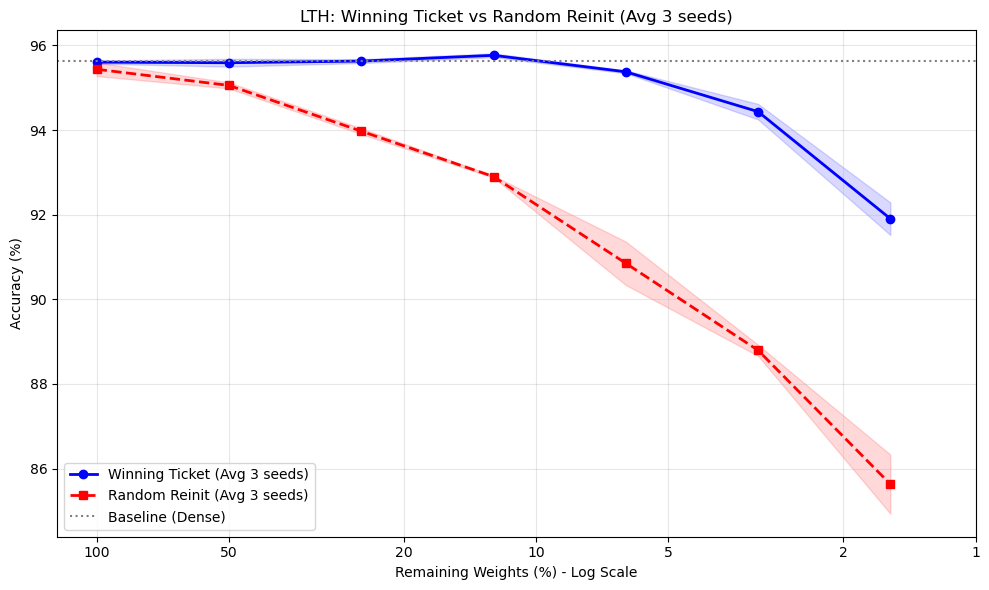

In [21]:
# X-Axis: Remaining Weights (derived from first seed)
ref_sparsity = [100 - (r['sparsity'] * 100) for r in results_per_seed[seeds[0]]]

# Collect Accuracies (Seeds x Iterations)
ticket_accs = np.array([[r['acc_ticket'] * 100 for r in history] for history in results_per_seed.values()])
random_accs = np.array([[r['acc_random'] * 100 for r in history] for history in results_per_seed.values()])

# Compute Mean & Std
ticket_mean = ticket_accs.mean(axis=0)
ticket_std = ticket_accs.std(axis=0)
random_mean = random_accs.mean(axis=0)
random_std = random_accs.std(axis=0)

plt.figure(figsize=(10, 6))

# 1. Plot Winning Ticket
plt.plot(ref_sparsity, ticket_mean, 'b-o', lw=2, label=f'Winning Ticket (Avg {len(seeds)} seeds)')
plt.fill_between(ref_sparsity, ticket_mean - ticket_std, ticket_mean + ticket_std, color='blue', alpha=0.15)

# 2. Plot Random Reinit
plt.plot(ref_sparsity, random_mean, 'r--s', lw=2, label=f'Random Reinit (Avg {len(seeds)} seeds)')
plt.fill_between(ref_sparsity, random_mean - random_std, random_mean + random_std, color='red', alpha=0.15)

# 3. Baseline
if 'baseline_acc' in locals():
    plt.axhline(baseline_acc * 100, c='gray', ls=':', label='Baseline (Dense)')

# 4. Formatting
plt.xscale('log')
plt.gca().invert_xaxis() # 100% -> 0%
plt.xticks([100, 50, 20, 10, 5, 2, 1], ['100', '50', '20', '10', '5', '2', '1'])
plt.minorticks_off()

plt.xlabel('Remaining Weights (%) - Log Scale')
plt.ylabel('Accuracy (%)')
plt.title(f'LTH: Winning Ticket vs Random Reinit (Avg {len(seeds)} seeds)')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()

save_path = os.path.join(checkpoint_path, 'lth_multiseed_final.png')
plt.savefig(save_path)
plt.show()

In [24]:
if 'results_per_seed' in locals():
    results = results_per_seed[seeds[0]]

print(f"{'Iter':<6} {'sparsity':<12} {'Ticket Acc':<12} {'Random Acc':<12}")
print("-" * 65)

for i, r in enumerate(results):
    print(f"{i+1:<6} {r['sparsity']*100:>8.1f}%    {r['acc_ticket']*100:>8.2f}%    {r['acc_random']*100:>8.2f}%")

print("-" * 65)
if 'baseline_acc' in locals():
    print(f"Baseline dense: {baseline_acc*100:.2f}%")

Iter   sparsity     Ticket Acc   Random Acc  
-----------------------------------------------------------------
1           0.0%       95.60%       95.64%
2          50.0%       95.48%       94.96%
3          75.0%       95.64%       93.88%
4          87.5%       95.83%       92.89%
5          93.8%       95.33%       90.20%
6          96.9%       94.17%       88.62%
7          98.4%       91.88%       84.67%
-----------------------------------------------------------------
Baseline dense: 95.64%


## 9. CNN sparsity per layer

In [25]:
seeds = [42, 123, 999]
imp_iterations = 5
prune_rate = 0.5
epochs_per_iteration = 5
layer_stats = {}  # Global storage for layer-wise sparsity across seeds

# Helper: Calculate actual model sparsity
def get_model_sparsity(model):
    zeros = 0
    total = 0
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            zeros += (m.weight == 0).sum().item()
            total += m.weight.numel()
    return zeros / total

In [26]:
for seed in seeds:
    print(f"seed {seed}")
    torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.manual_seed(seed)
    
    # Initialize a fresh model for each seed
    model = QuickDrawCNN(num_classes=len(categories)).to(device)
    initial_weights = copy.deepcopy(model.state_dict())
    
    for i in range(imp_iterations):
        print(f"   IMP Round {i+1}/{imp_iterations}")
        
        # Train the model
        train_model(model, train_loader, val_loader, epochs_per_iteration, learning_rate, device)
        
        # Prepare for next round: Prune & Rewind
        if i < imp_iterations - 1:
            layers = [(m, 'weight') for m in model.modules() if isinstance(m, (nn.Conv2d, nn.Linear))]
            # Global Magnitude Pruning
            prune.global_unstructured(layers, prune.L1Unstructured, amount=prune_rate)
            
            masks = {n: m.weight_mask.clone() for n, m in model.named_modules() if hasattr(m, 'weight_mask')}
            for m, _ in layers: prune.remove(m, 'weight')
            
            # Rewind to original initialization (LTH principle)
            model.load_state_dict(initial_weights) 
            for n, m in model.named_modules():
                if n in masks: prune.custom_from_mask(m, 'weight', masks[n])

    # collect final layer wise sparsity
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            total = module.weight.numel()
            zeros = (module.weight == 0).sum().item()
            layer_sparsity = (zeros / total) * 100
            
            if name not in layer_stats:
                layer_stats[name] = []
            layer_stats[name].append(layer_sparsity)

    # Cleanup to save GPU memory
    del model; clear_memory()

seed 42
   IMP Round 1/5


Loss: 0.1302, Train: 96.11%, Val: 95.48%: 100%|██████████| 5/5 [00:24<00:00,  4.80s/it]


   IMP Round 2/5


Loss: 0.1214, Train: 96.32%, Val: 95.75%: 100%|██████████| 5/5 [00:22<00:00,  4.55s/it]


   IMP Round 3/5


Loss: 0.1095, Train: 96.71%, Val: 95.70%: 100%|██████████| 5/5 [00:22<00:00,  4.53s/it]


   IMP Round 4/5


Loss: 0.1056, Train: 96.77%, Val: 95.71%: 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


   IMP Round 5/5


Loss: 0.1284, Train: 96.17%, Val: 95.59%: 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


seed 123
   IMP Round 1/5


Loss: 0.1216, Train: 96.33%, Val: 95.69%: 100%|██████████| 5/5 [00:22<00:00,  4.40s/it]


   IMP Round 2/5


Loss: 0.1103, Train: 96.66%, Val: 95.55%: 100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


   IMP Round 3/5


Loss: 0.0985, Train: 96.93%, Val: 95.88%: 100%|██████████| 5/5 [00:21<00:00,  4.35s/it]


   IMP Round 4/5


Loss: 0.1018, Train: 96.82%, Val: 95.61%: 100%|██████████| 5/5 [00:21<00:00,  4.40s/it]


   IMP Round 5/5


Loss: 0.1211, Train: 96.29%, Val: 95.53%: 100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


seed 999
   IMP Round 1/5


Loss: 0.1287, Train: 96.14%, Val: 95.38%: 100%|██████████| 5/5 [00:22<00:00,  4.53s/it]


   IMP Round 2/5


Loss: 0.1219, Train: 96.35%, Val: 95.52%: 100%|██████████| 5/5 [00:23<00:00,  4.70s/it]


   IMP Round 3/5


Loss: 0.1108, Train: 96.68%, Val: 95.67%: 100%|██████████| 5/5 [00:24<00:00,  4.99s/it]


   IMP Round 4/5


Loss: 0.1057, Train: 96.79%, Val: 95.74%: 100%|██████████| 5/5 [00:25<00:00,  5.06s/it]


   IMP Round 5/5


Loss: 0.1285, Train: 96.08%, Val: 95.64%: 100%|██████████| 5/5 [00:25<00:00,  5.05s/it]


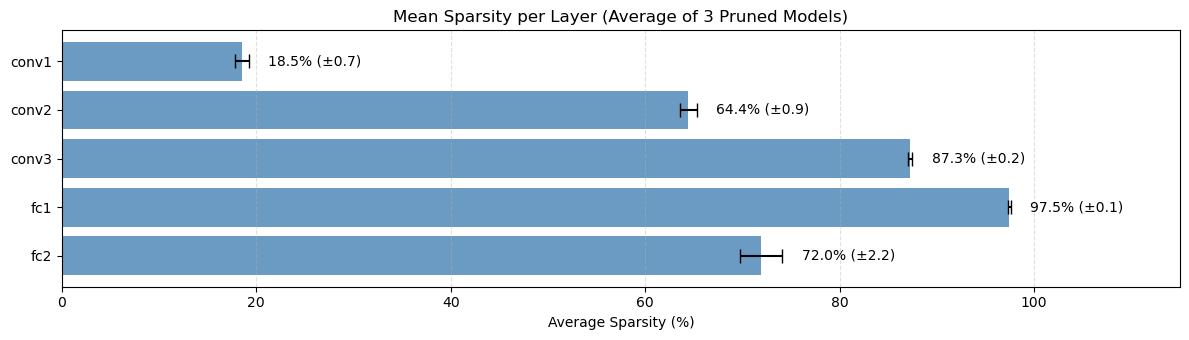

In [27]:
names = list(layer_stats.keys())
means = [np.mean(layer_stats[n]) for n in names]
stds = [np.std(layer_stats[n]) for n in names]

plt.figure(figsize=(12, len(names) * 0.7))
# Bar chart with error bars representing the standard deviation
bars = plt.barh(names, means, xerr=stds, color='steelblue', alpha=0.8, capsize=5)

plt.xlabel('Average Sparsity (%)')
plt.title(f'Mean Sparsity per Layer (Average of {len(seeds)} Pruned Models)')
plt.xlim(0, 115) 
plt.gca().invert_yaxis() # Entry layers at the top
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Add formatted labels (Mean ± Std Dev)
for bar, m, s in zip(bars, means, stds):
    plt.text(m + s + 2, bar.get_y() + bar.get_height()/2, 
             f'{m:.1f}% (±{s:.1f})', va='center')

plt.tight_layout()
plt.show()